<a href="https://colab.research.google.com/github/cyyeh/ds-portfolios/blob/master/projects/youbike/notebooks/1.0-weather-air-data-eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taipei Weather and Air Condition Data in 2018 EDA

- weather station: 臺北市中正區公園路64號
- air condition station: 台北市中山區測站 

---

- weather data source: https://e-service.cwb.gov.tw/HistoryDataQuery/index.jsp
- air condition data source: https://erdb.epa.gov.tw/DataRepository/EnvMonitor/AirQualityMonitorHourData.aspx

## Get Data

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# install chinese font
!wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip
!unzip NotoSerifCJKtc-hinted.zip
!mv NotoSerifCJKtc-Medium.otf /usr/share/fonts/truetype/

--2020-03-10 23:13:46--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c04::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130464138 (124M) [application/zip]
Saving to: ‘NotoSerifCJKtc-hinted.zip’

NotoSerifCJKtc-hint 100%[===================>] 124.42M  29.8MB/s    in 4.2s    

2020-03-10 23:13:51 (29.8 MB/s) - ‘NotoSerifCJKtc-hinted.zip’ saved [130464138/130464138]

Archive:  NotoSerifCJKtc-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSerifCJKtc-Black.otf  
  inflating: NotoSerifCJKtc-Bold.otf  
  inflating: NotoSerifCJKtc-ExtraLight.otf  
  inflating: NotoSerifCJKtc-Light.otf  
  inflating: NotoSerifCJKtc-Medium.otf  
  inflating: NotoSerifCJKtc-Regular.otf  
  inflating: NotoSe

In [0]:
import dask.dataframe as dd
import dask.bag as db
import pandas as pd
import numpy as np
import json

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/NotoSerifCJKtc-Medium.otf'
font_prop = fm.FontProperties(fname=font_path, size=15)

import warnings
warnings.filterwarnings('ignore')

### Auxiliary Methods

In [0]:
def _add_date_column(df, date_str):
  date_column = []
  date = pd.to_datetime(date_str)
  for index, _ in df.iterrows():
    date_with_hour = date + pd.DateOffset(hours=index)
    date_column.append(date_with_hour)

    if (index + 1) % 24 == 0:
      date += pd.DateOffset(days=1)
  df['日期'] = date_column
  return df

### Weather Data

In [0]:
def get_weather_history_data(year=2018):
  weather_history_data_path = f"drive/My Drive/taipei-weather-{year}/*.csv"

  col_names=[
    '氣溫(℃)',
    '相對溼度(%)',
    '風速(m/s)',
    '風向(360degree)',
    '降水量(mm)'
  ]

  df = (dd.read_csv(
            weather_history_data_path,
            usecols=[3, 5, 6, 7, 10],
            header=0,
            names=col_names,
            na_values=['/', 'X', 'T', 'V', '...'],
            assume_missing=True
          )
          .compute()
        )

  # add datetime
  df = _add_date_column(df, f"1/1/{year}")

  # set datetime as index
  df = df.set_index('日期')

  # imputation
  df = df.fillna(method='ffill')

  return df

In [0]:
weather_df = get_weather_history_data()

In [0]:
weather_df

,氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),降水量(mm)
日期,,,,,
2018-01-01 00:00:00,15.9,71.0,3.3,50.0,0.0
2018-01-01 01:00:00,16.0,69.0,2.8,60.0,0.0
2018-01-01 02:00:00,16.1,69.0,2.5,60.0,0.0
2018-01-01 03:00:00,16.2,70.0,3.0,70.0,0.0
2018-01-01 04:00:00,16.2,70.0,2.9,90.0,0.0
...,...,...,...,...,...
2018-06-15 19:00:00,25.2,81.0,1.2,230.0,0.0
2018-06-15 20:00:00,25.2,81.0,1.5,240.0,0.0
2018-06-15 21:00:00,25.0,81.0,1.3,210.0,0.0


### Air Data

In [0]:
def get_air_history_data(year=2018):
  air_history_data_path = f"drive/My Drive/taipei-air-{year}.csv"

  usecols_indices = [i for i in range(4, 30)]
  df = (pd.read_csv(air_history_data_path, 
                    usecols=usecols_indices,
                    na_values=['x']))
  # remove redundant rows
  df = df.iloc[1:2969]

  # reverse order, since 12/31 is the first row, 1/1 is the last row
  df['監測日期'] = pd.to_datetime(df['監測日期'])
  df = df.sort_values('監測日期')

  # imputation
  df = df.fillna(method='ffill')

  df = df.set_index('監測日期')
  
  # make air_df
  date_range = pd.date_range(start=f"1/1/{year}", end=f"6/15/{year}")
  air_df = pd.DataFrame()
  for date in date_range:
    date_str = str(date).split(' ')[0]
    if date_str in df.index:
      sub_df = df.loc[date_str].T
      headers = sub_df.iloc[0]
      sub_df = pd.DataFrame(sub_df.values[1:], columns=headers)

      # add datetime
      sub_df = _add_date_column(sub_df, date_str)

      if air_df.empty:
        air_df = sub_df
      else:
        air_df = pd.concat([air_df, sub_df], sort=True)

  air_df = air_df.set_index('日期')

  mapper = {
    '小時風向值  ()': '小時風向值',
    '細懸浮微粒 PM 2.5  (μg/m 3 )': '細懸浮微粒(μg/m^3)',
    '總碳氫化合物 THC (ppm)': '總碳氫化合物(ppm)',
    '小時風速值 WS_HR (m/sec)': '小時風速值(m/sec)',
    '小時風向值 WD_HR (degrees)': '小時風向值(degrees)',
    '風向 WIND_DIREC (degrees)': '風向(degrees)',
    '相對濕度 RH (percent)': '相對濕度(percent)',
    '懸浮微粒 PM 10  (μg/m 3 )': '懸浮微粒(μg/m^3)',
    '甲烷 CH4 (ppm)': '甲烷(ppm)',
    '風速 WIND_SPEED (m/sec)': '風速(m/sec)',
    '非甲烷碳氫化合物 NMHC (ppm)': '非甲烷碳氫化合物(ppm)',
    '一氧化碳 CO (ppm)': '一氧化碳(ppm)',
    '二氧化氮 NO2 (ppb)': '二氧化氮(ppb)',
    '氮氧化物 NOx (ppb)': '氮氧化物(ppb)',
    '二氧化硫 SO2 (ppb)': '二氧化硫(ppb)',
    '臭氧 O3 (ppb)': '臭氧(ppb)',
    '溫度 AMB_TEMP (℃)': '溫度(℃)'
  }
  air_df = air_df.rename(columns=mapper)

  '''
  經過相關性分析：
  非甲烷碳氫化合物與甲烷相關係數過高，去除非甲烷碳氫化合物
  溫度,相對濕度,風向值,風速值已出現在天氣資料中，故去除
  '''
  usecols = [
    '細懸浮微粒(μg/m^3)',
    '總碳氫化合物(ppm)',
    '懸浮微粒(μg/m^3)',
    '甲烷(ppm)',
    '一氧化碳(ppm)',
    '二氧化氮(ppb)',
    '氮氧化物(ppb)',
    '二氧化硫(ppb)',
    '臭氧(ppb)'
  ]
  return air_df[usecols]

In [0]:
air_df = get_air_history_data()

In [0]:
air_df

,細懸浮微粒(μg/m^3),總碳氫化合物(ppm),懸浮微粒(μg/m^3),甲烷(ppm),一氧化碳(ppm),二氧化氮(ppb),氮氧化物(ppb),二氧化硫(ppb),臭氧(ppb)
日期,,,,,,,,,
2018-01-01 00:00:00,12,2,80,1.9,0.48,16,17,1.7,32
2018-01-01 01:00:00,19,2,76,1.9,0.51,16,18,2.4,33
2018-01-01 02:00:00,18,2,76,1.9,0.41,13,14,2.3,37
2018-01-01 03:00:00,14,2,76,1.9,0.35,9,10,2.7,40
2018-01-01 04:00:00,9,2,71,1.9,0.32,8.9,11,2,39
...,...,...,...,...,...,...,...,...,...
2018-06-15 19:00:00,10,2.6,30,2.1,1.31,47,67,3.9,9.3
2018-06-15 20:00:00,10,2.7,34,2.1,1.28,49,68,4.2,3.9
2018-06-15 21:00:00,8,2.6,23,2.1,1.1,48,63,4.1,3.1


### Combine Weather Data and Air Data

In [0]:
def get_weather_air_history_data(year=2018):
  weather_df = get_weather_history_data(year=year)
  air_df = get_air_history_data(year=year)

  weather_air_df = pd.concat([air_df, weather_df], axis=1, sort=True)
  weather_air_df = weather_air_df.fillna(method='ffill')

  return weather_air_df

In [0]:
weather_air_df = get_weather_air_history_data()

In [0]:
weather_air_df

,細懸浮微粒(μg/m^3),總碳氫化合物(ppm),懸浮微粒(μg/m^3),甲烷(ppm),一氧化碳(ppm),二氧化氮(ppb),氮氧化物(ppb),二氧化硫(ppb),臭氧(ppb),氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),降水量(mm)
日期,,,,,,,,,,,,,,
2018-01-01 00:00:00,12.0,2.0,80.0,1.9,0.48,16.0,17.0,1.7,32.0,15.9,71.0,3.3,50.0,0.0
2018-01-01 01:00:00,19.0,2.0,76.0,1.9,0.51,16.0,18.0,2.4,33.0,16.0,69.0,2.8,60.0,0.0
2018-01-01 02:00:00,18.0,2.0,76.0,1.9,0.41,13.0,14.0,2.3,37.0,16.1,69.0,2.5,60.0,0.0
2018-01-01 03:00:00,14.0,2.0,76.0,1.9,0.35,9.0,10.0,2.7,40.0,16.2,70.0,3.0,70.0,0.0
2018-01-01 04:00:00,9.0,2.0,71.0,1.9,0.32,8.9,11.0,2.0,39.0,16.2,70.0,2.9,90.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-15 19:00:00,10.0,2.6,30.0,2.1,1.31,47.0,67.0,3.9,9.3,25.2,81.0,1.2,230.0,0.0
2018-06-15 20:00:00,10.0,2.7,34.0,2.1,1.28,49.0,68.0,4.2,3.9,25.2,81.0,1.5,240.0,0.0
2018-06-15 21:00:00,8.0,2.6,23.0,2.1,1.10,48.0,63.0,4.1,3.1,25.0,81.0,1.3,210.0,0.0


## EDA

### Auxiliary Methods

In [0]:
def resample_weather_air_df(df, freq=None):
  return df.resample(freq).mean() if freq else df

In [0]:
def draw_line_plot_by_column(df, font_prop=font_prop):
  for column in df.columns:
    plt.figure(figsize=(12, 8))
    x = df.index
    y = df[column]
    plt.xticks(color='white', fontsize=14)
    plt.yticks(color='white', fontsize=14)
    plt.title(column, fontproperties=font_prop, fontsize=16)
    plt.plot(x, y)
    plt.show()
    print()

In [0]:
def draw_heatmap_by_column(df, font_prop=font_prop):
  f = plt.figure(figsize=(12, 12))
  plt.matshow(df.corr(), fignum=f.number)
  plt.xticks(range(df.shape[1]), df.columns, fontproperties=font_prop, fontsize=14, rotation=75, color='white')
  plt.yticks(range(df.shape[1]), df.columns, fontproperties=font_prop, fontsize=14, color='white')
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=14, labelcolor='white', color='white')

### Correlation between columns

In [0]:
weather_air_df.corr()

,細懸浮微粒(μg/m^3),總碳氫化合物(ppm),懸浮微粒(μg/m^3),甲烷(ppm),一氧化碳(ppm),二氧化氮(ppb),氮氧化物(ppb),二氧化硫(ppb),臭氧(ppb),氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),降水量(mm)
細懸浮微粒(μg/m^3),1.000000,0.021709,0.629327,0.338321,0.114533,0.320254,0.269837,-0.040011,0.214339,0.221959,-0.170525,-0.212099,0.221208,-0.088898
總碳氫化合物(ppm),0.021709,1.000000,0.012005,0.371492,0.111171,0.076522,0.110231,0.062831,0.073573,0.020517,0.004865,0.029057,0.031744,0.018461
懸浮微粒(μg/m^3),0.629327,0.012005,1.000000,0.023190,0.039901,0.223515,0.199771,-0.048252,0.179444,0.147350,-0.347359,-0.075946,0.107037,-0.153784
甲烷(ppm),0.338321,0.371492,0.023190,1.000000,0.235361,0.133913,0.105274,0.098744,0.285593,0.039400,-0.005594,-0.000572,-0.005848,0.010870
一氧化碳(ppm),0.114533,0.111171,0.039901,0.235361,1.000000,0.099359,0.039421,0.123350,0.095956,0.054348,-0.050370,0.024672,0.028679,-0.010325
二氧化氮(ppb),0.320254,0.076522,0.223515,0.133913,0.099359,1.000000,0.565745,0.023012,-0.201512,0.008285,0.001717,-0.147227,0.082231,-0.001259
氮氧化物(ppb),0.269837,0.110231,0.199771,0.105274,0.039421,0.565745,1.000000,0.045068,-0.422759,-0.059009,0.108400,-0.262023,0.102909,0.013371
二氧化硫(ppb),-0.040011,0.062831,-0.048252,0.098744,0.123350,0.023012,0.045068,1.000000,-0.008709,-0.115790,0.092809,0.061084,-0.040375,-0.003933
臭氧(ppb),0.214339,0.073573,0.179444,0.285593,0.095956,-0.201512,-0.422759,-0.008709,1.000000,0.194422,-0.433126,0.272564,-0.001565,-0.062327
氣溫(℃),0.221959,0.020517,0.147350,0.039400,0.054348,0.008285,-0.059009,-0.115790,0.194422,1.000000,-0.540731,-0.105268,0.348704,-0.160291


### Correlation using heatmap

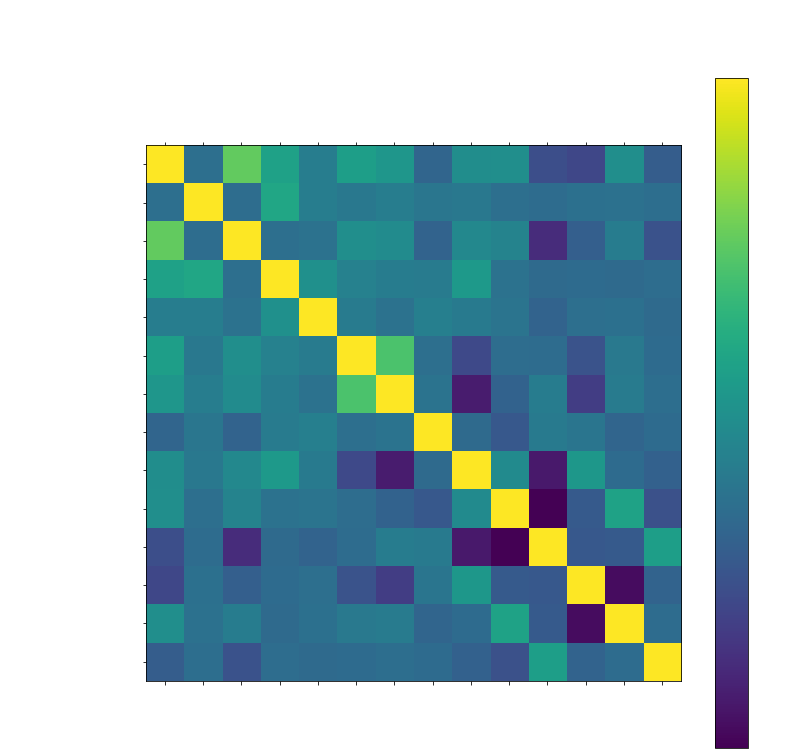

In [0]:
draw_heatmap_by_column(weather_air_df)

### line plot for each column(year)

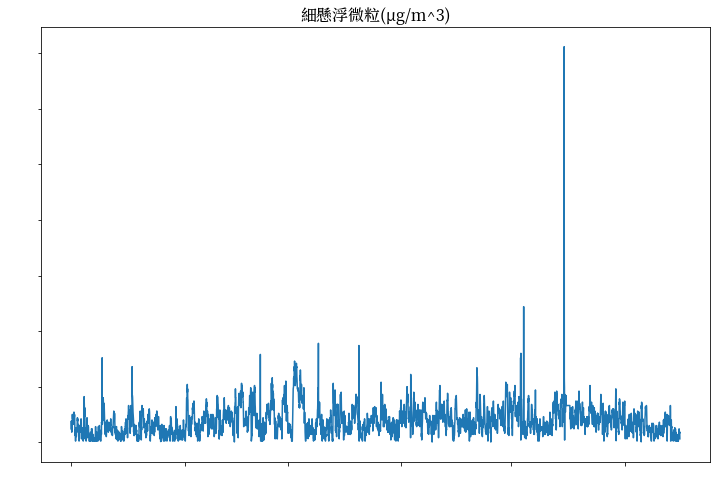

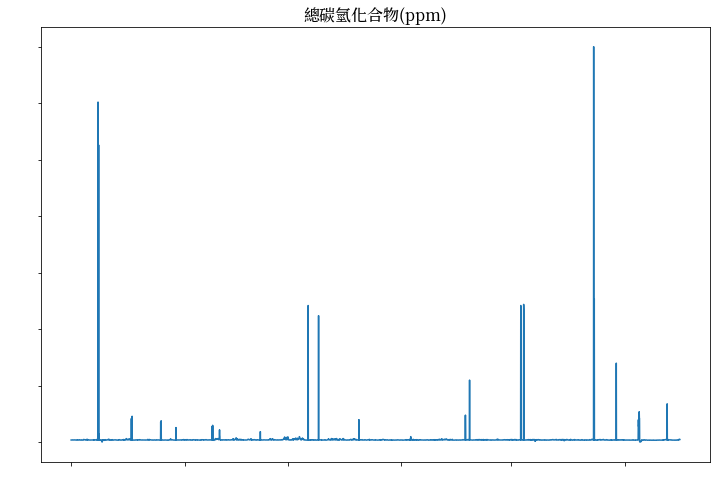

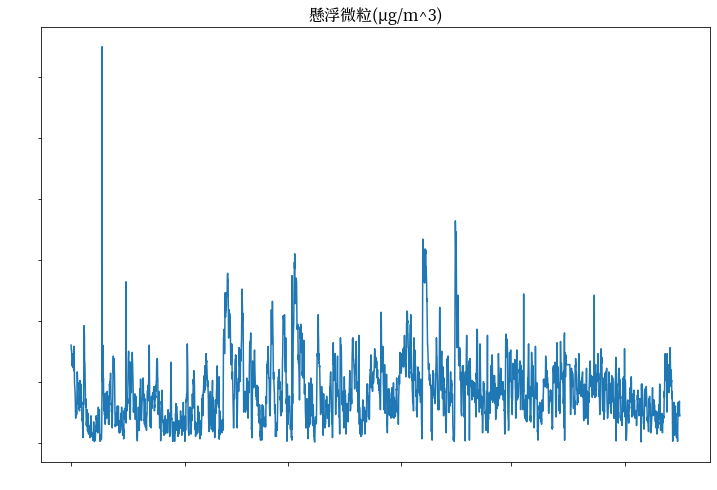

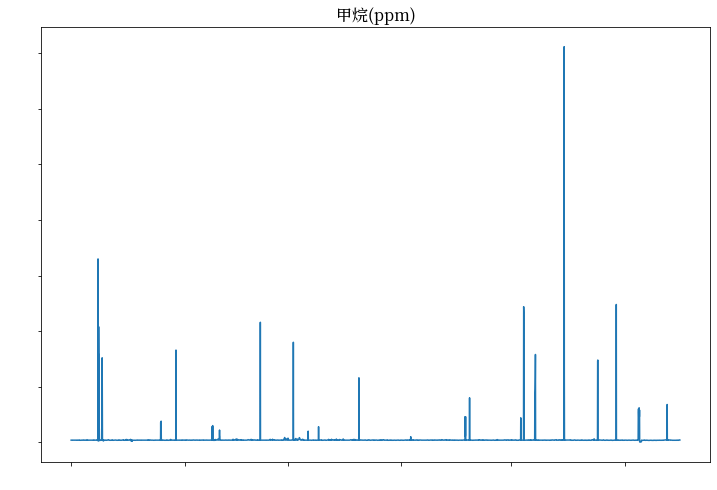

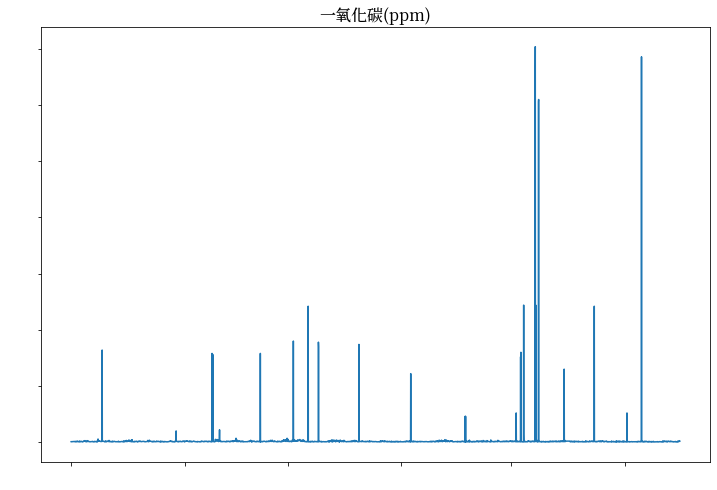

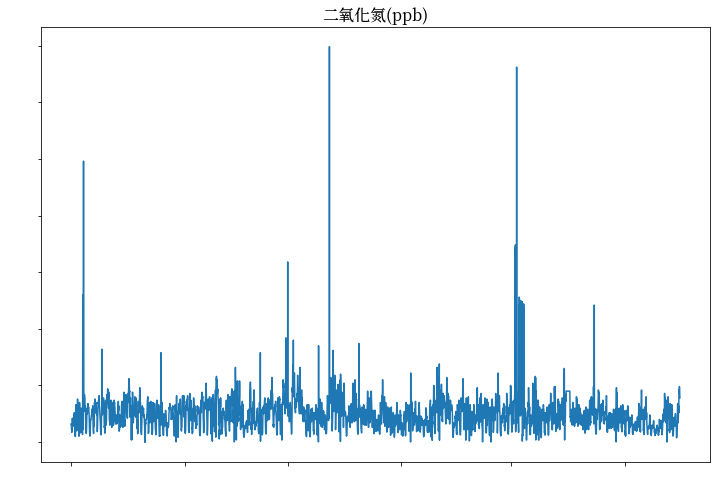

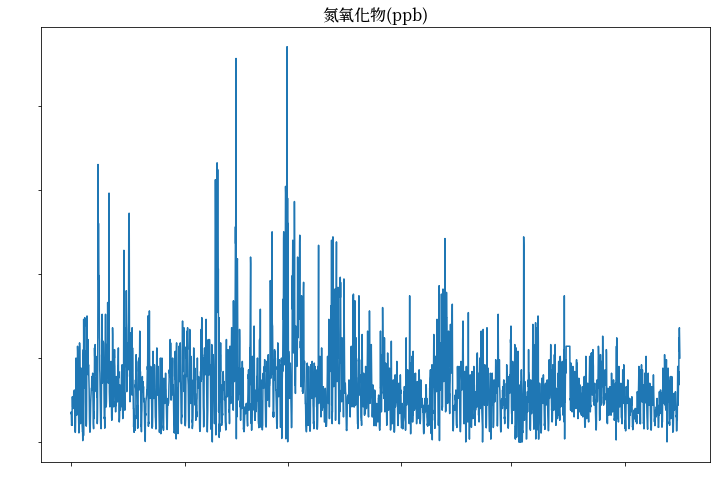

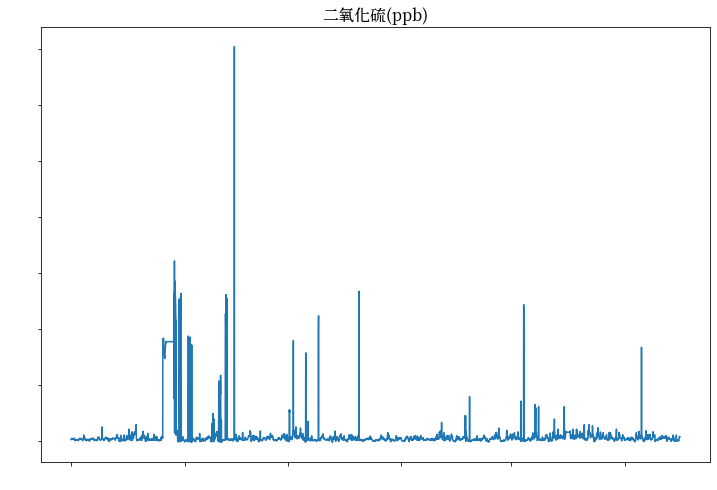

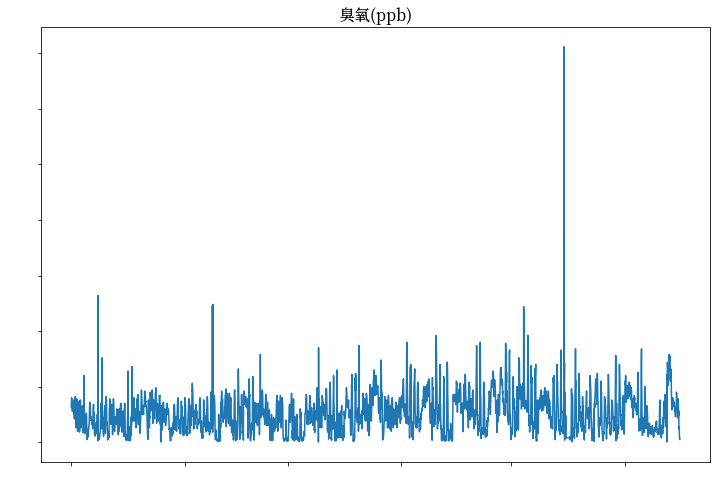

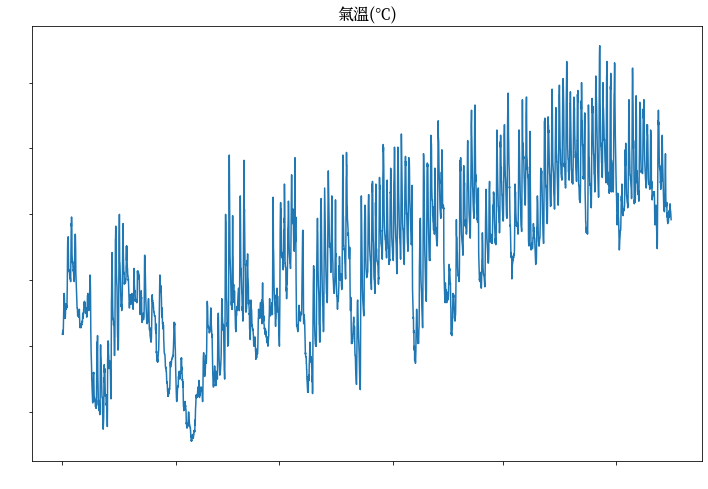

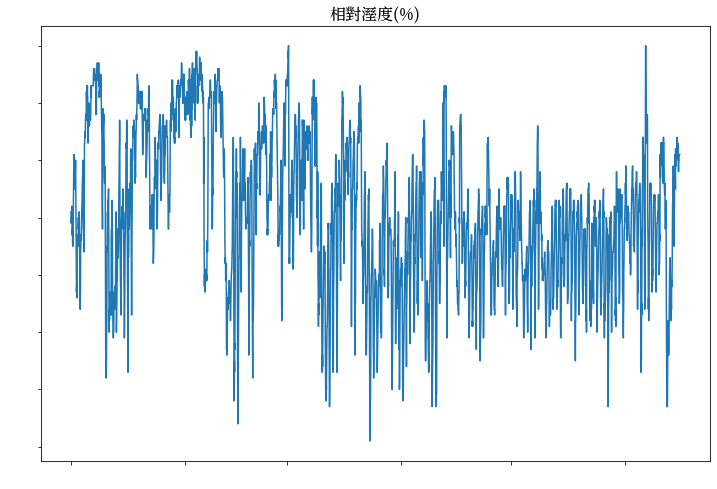

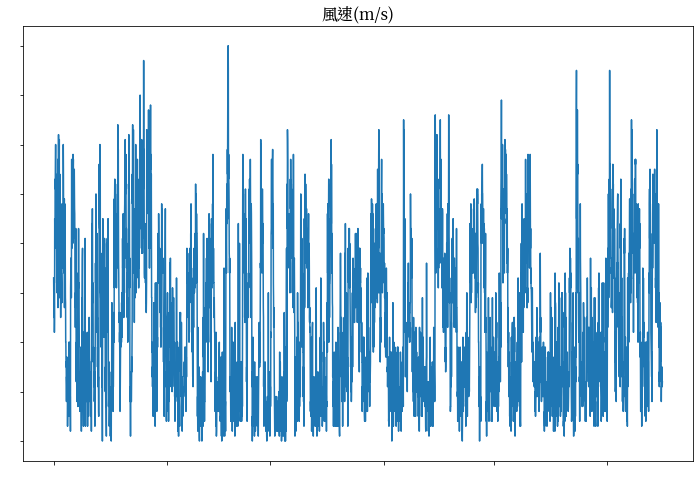

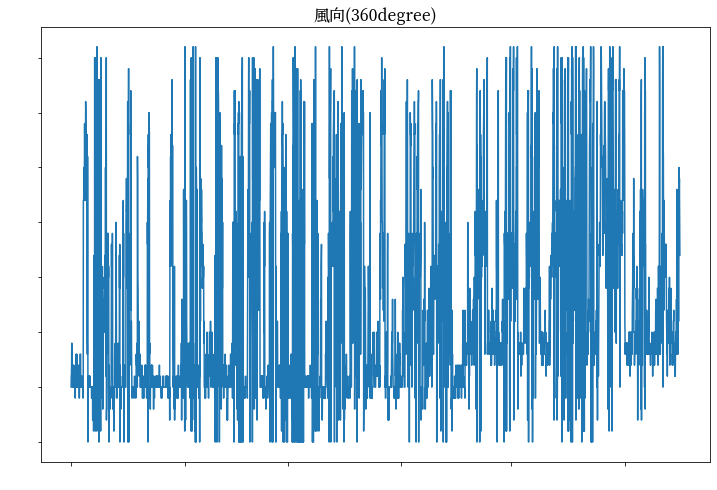

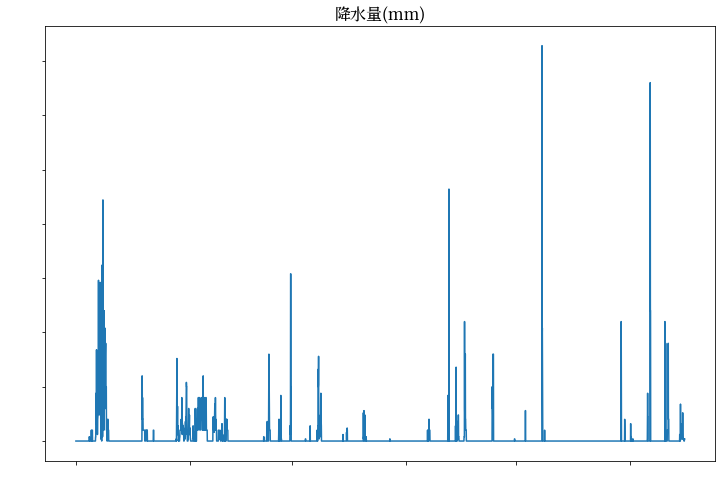

In [0]:
weather_air_df_year = resample_weather_air_df(weather_air_df)
draw_line_plot_by_column(weather_air_df_year)

### line plot for each column(season)

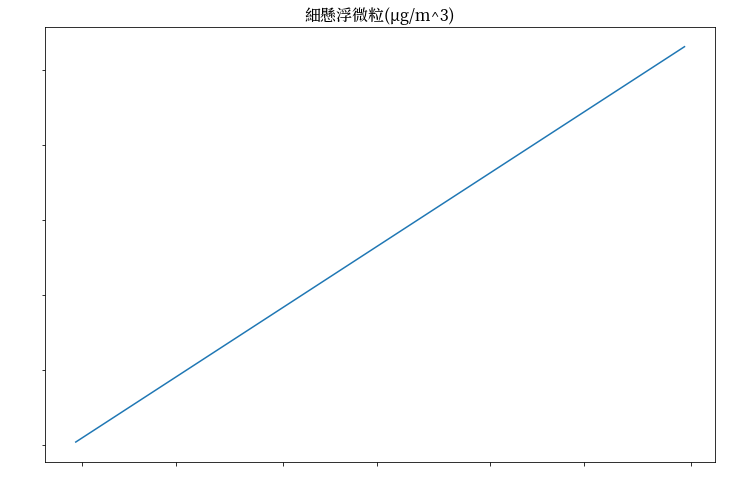

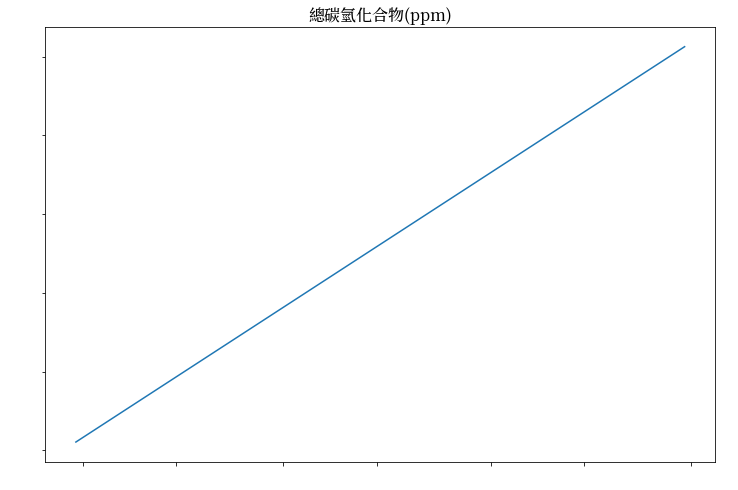

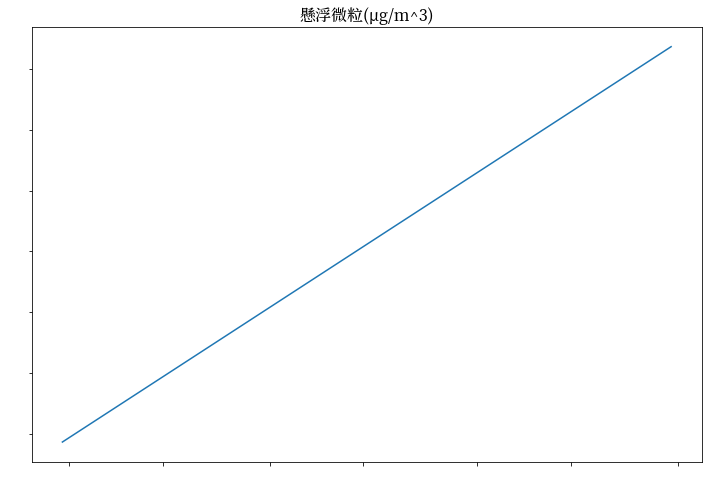

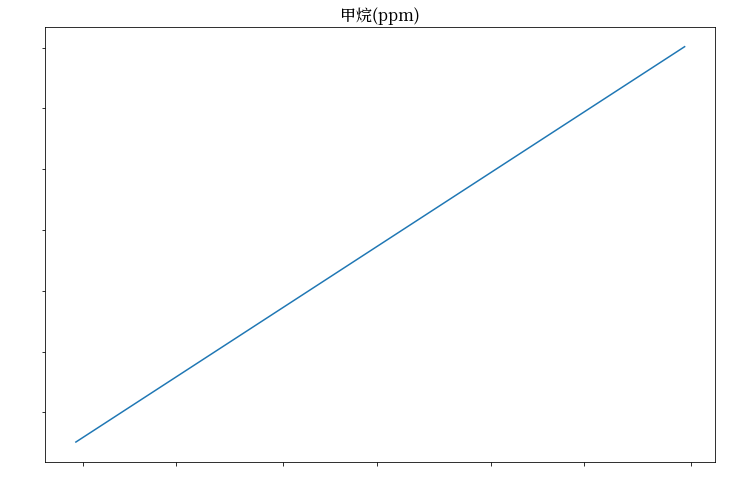

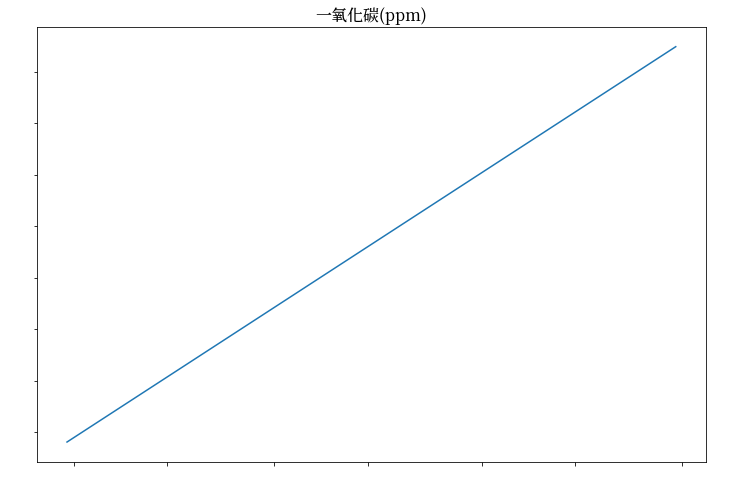

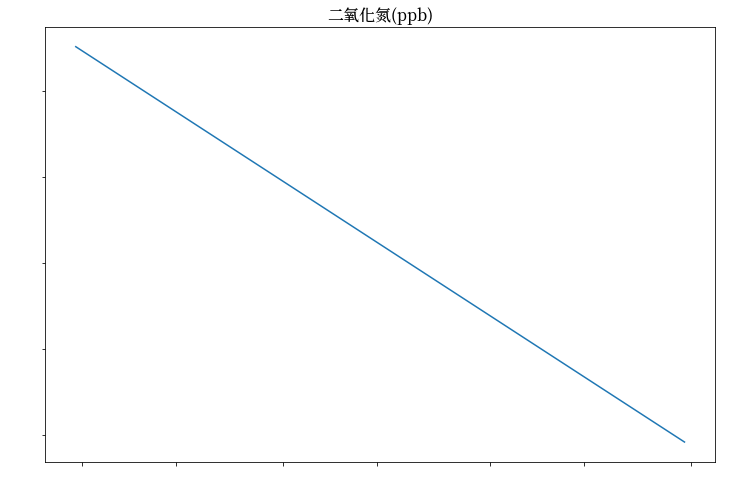

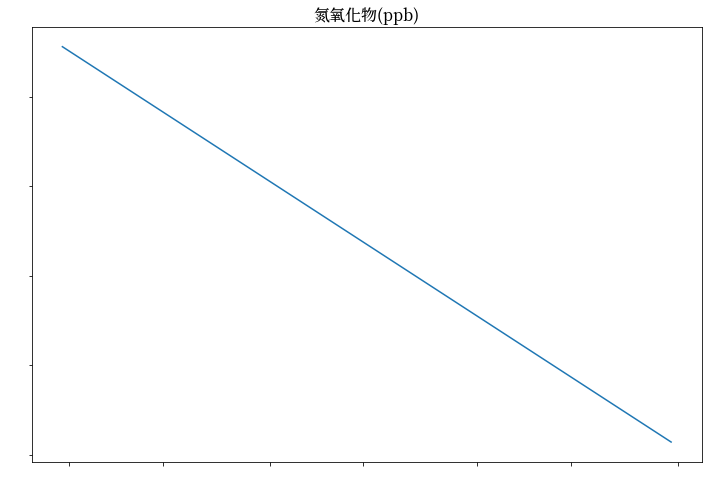

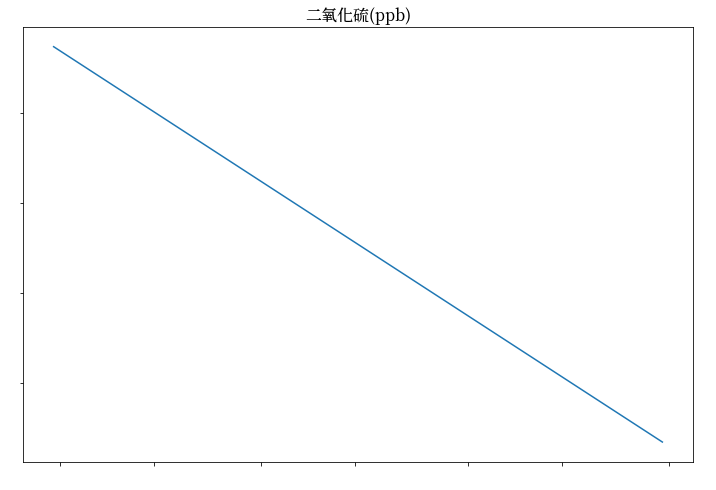

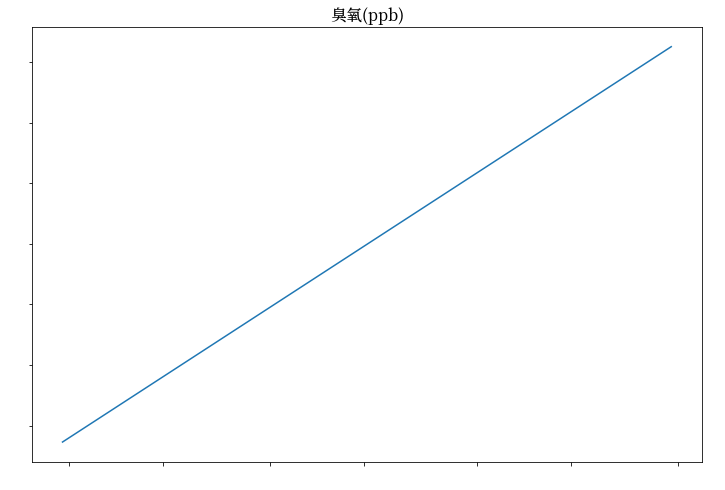

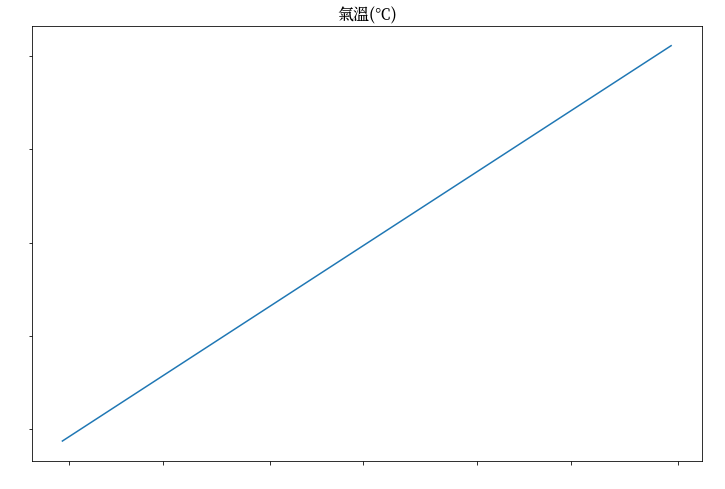

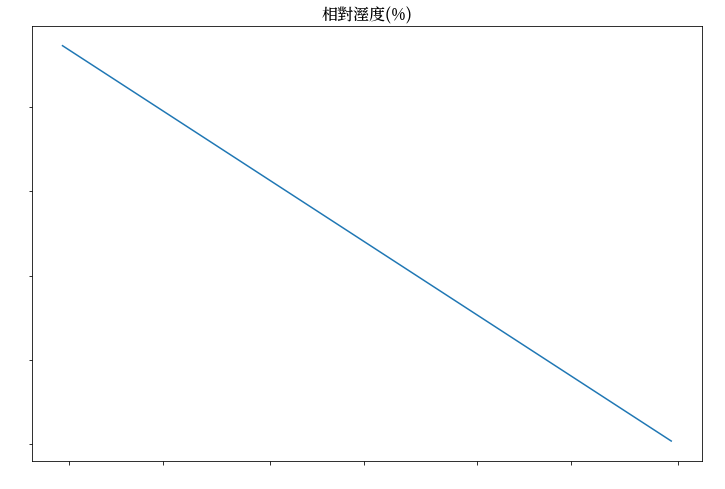

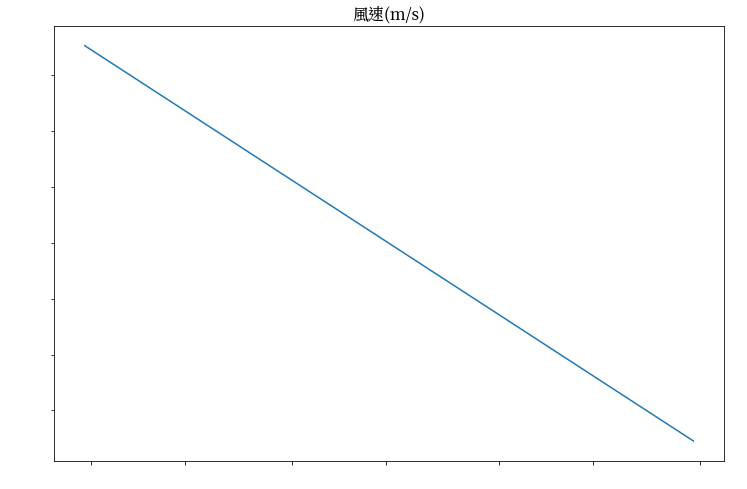

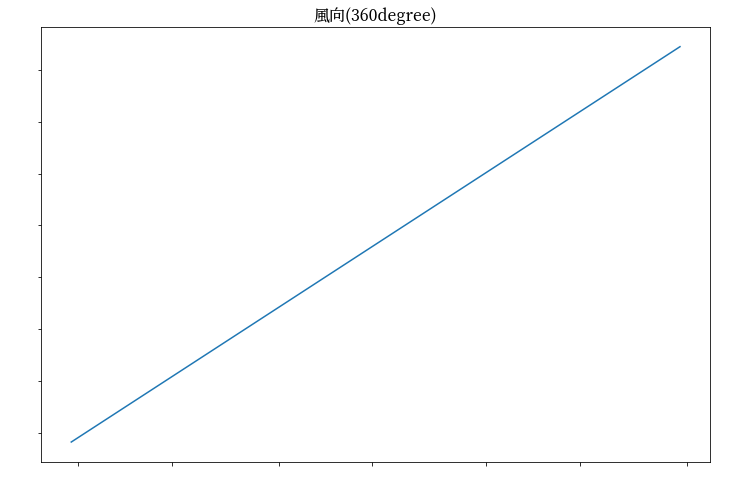

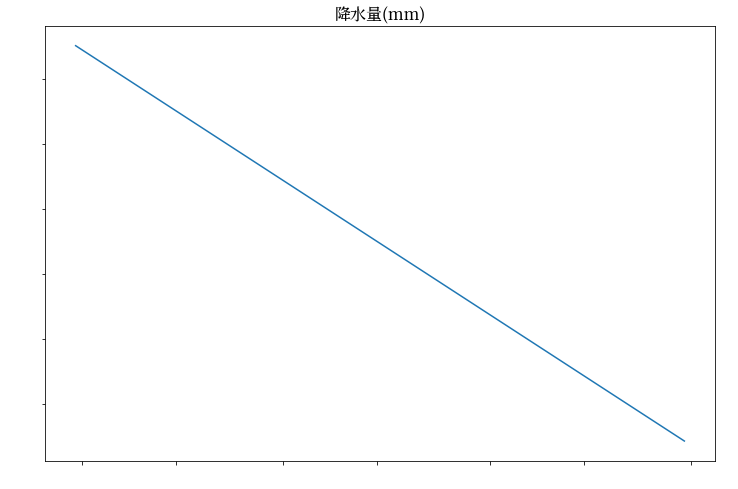

In [0]:
weather_air_df_season = resample_weather_air_df(weather_air_df, freq='Q')
draw_line_plot_by_column(weather_air_df_season)

### line plot for each column(month)

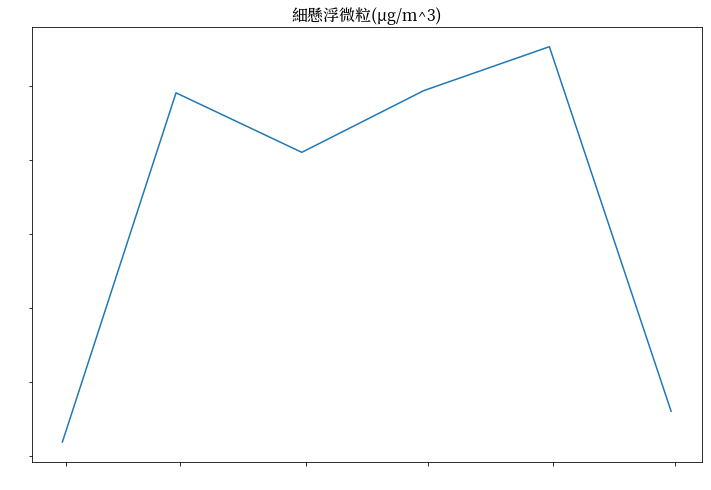

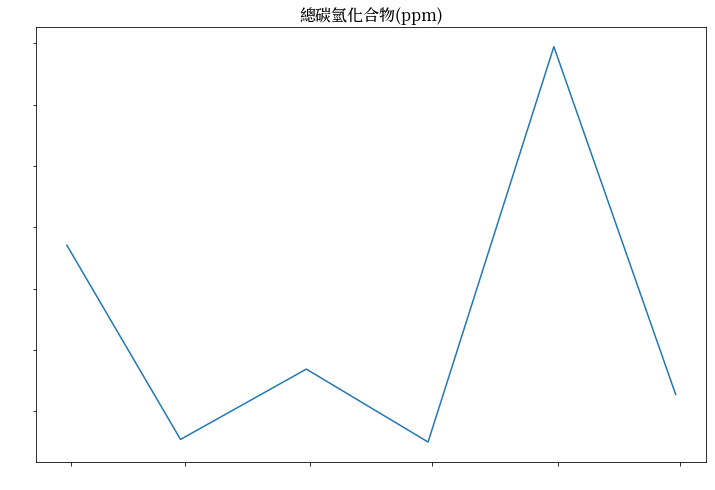

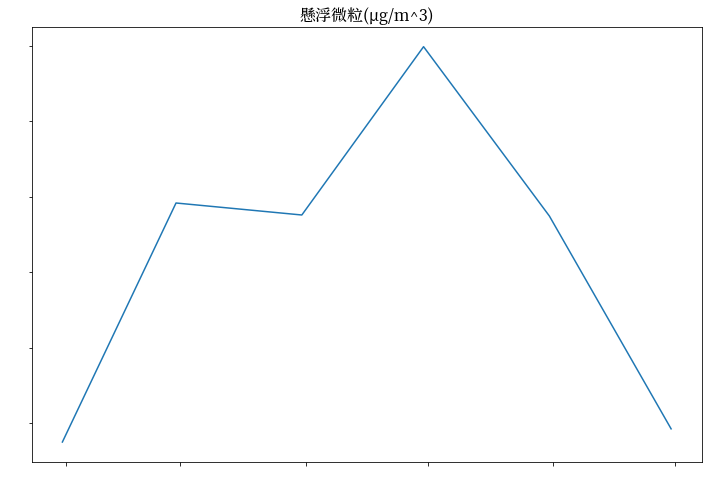

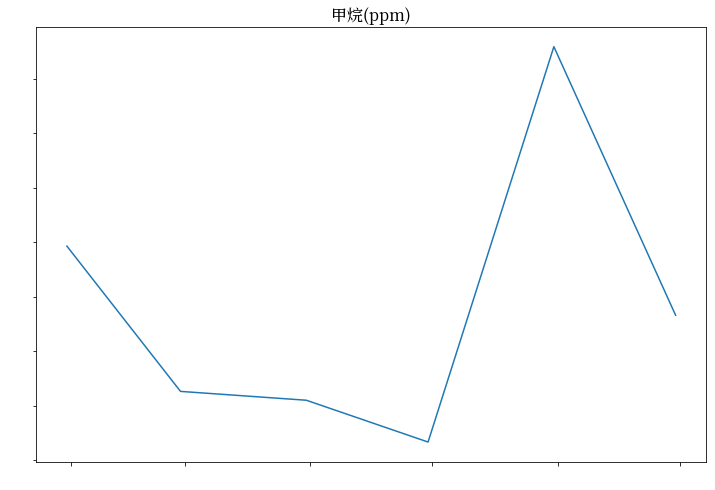

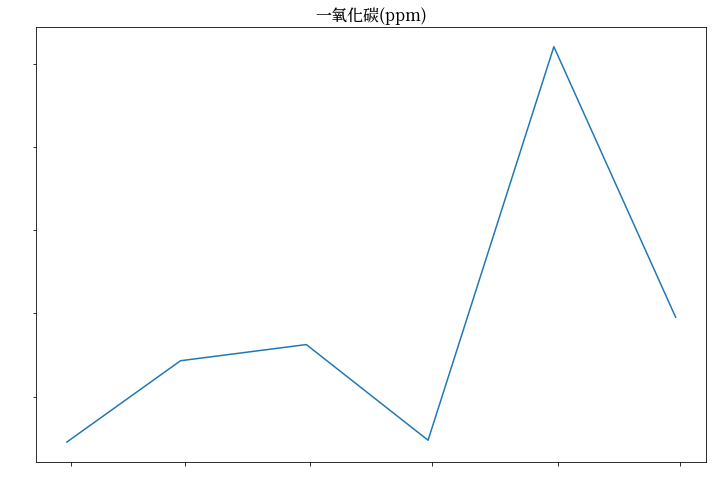

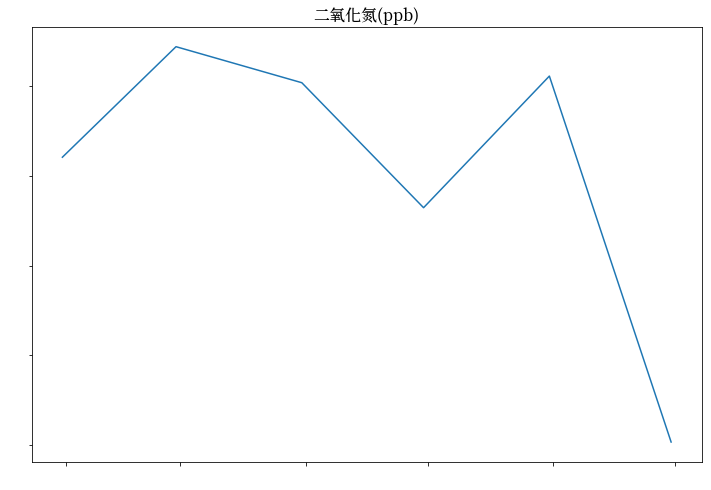

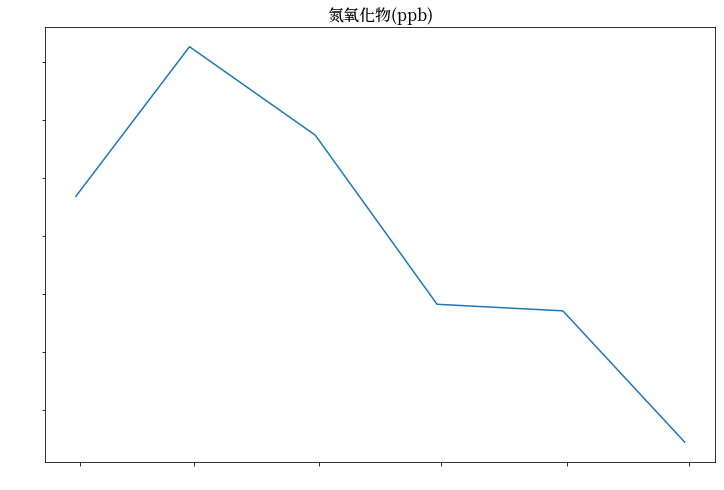

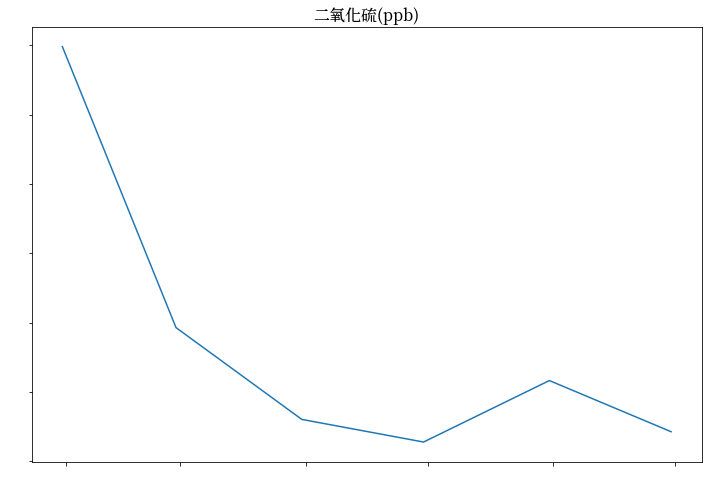

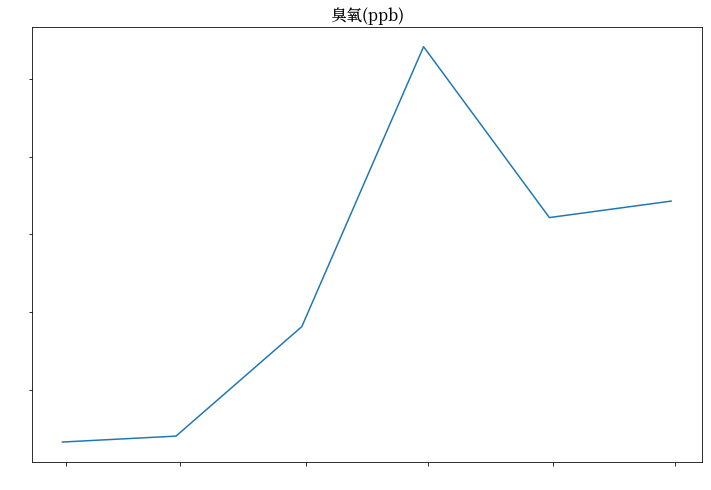

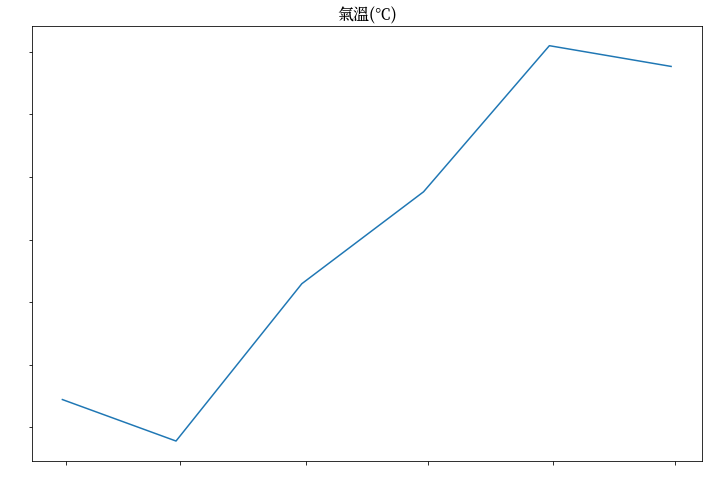

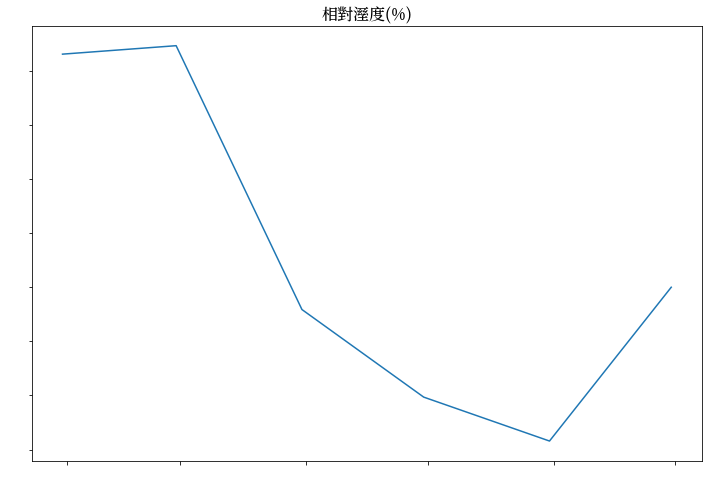

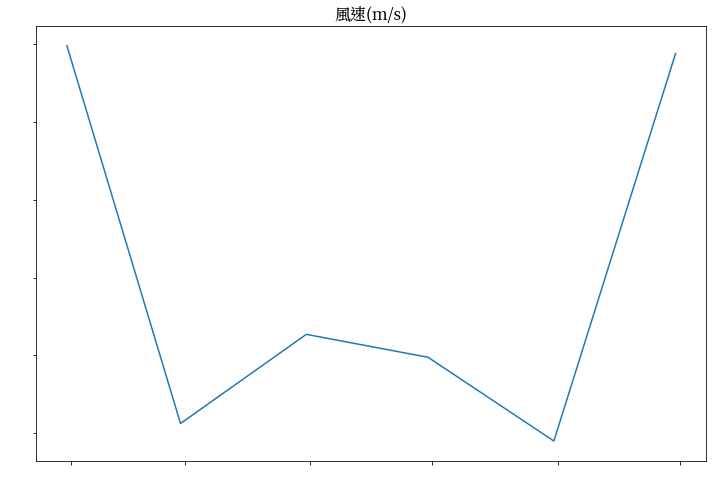

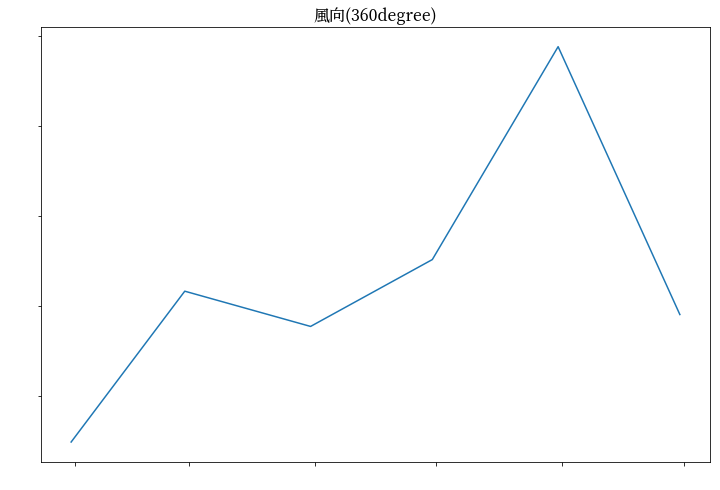

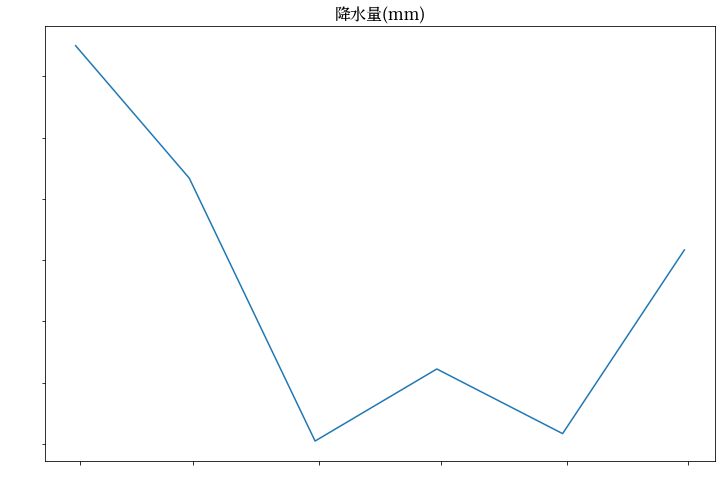

In [0]:
weather_air_df_month = resample_weather_air_df(weather_air_df, freq='M')
draw_line_plot_by_column(weather_air_df_month)

### line plot for each column(day)

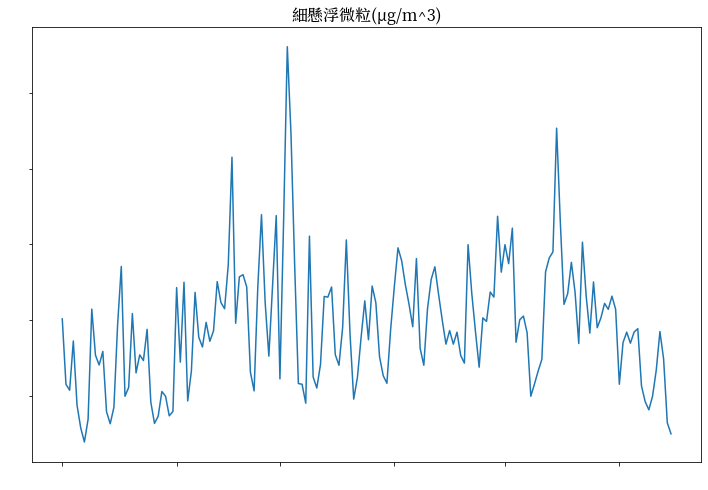

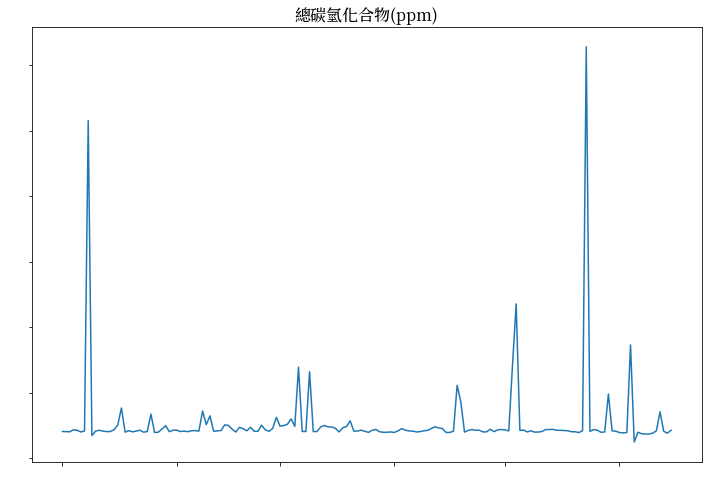

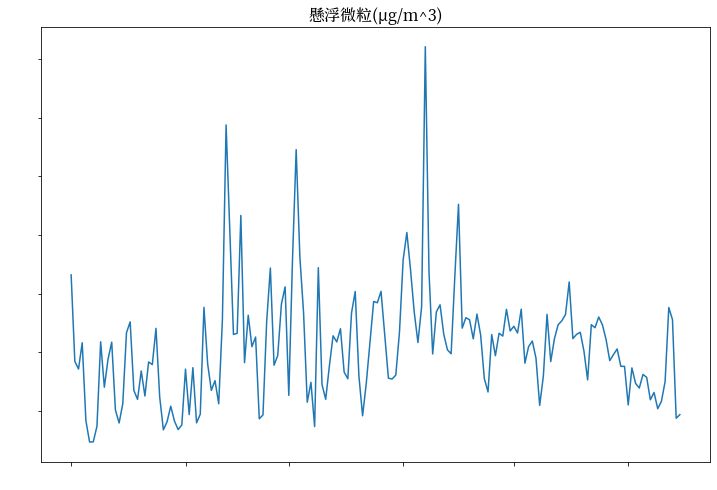

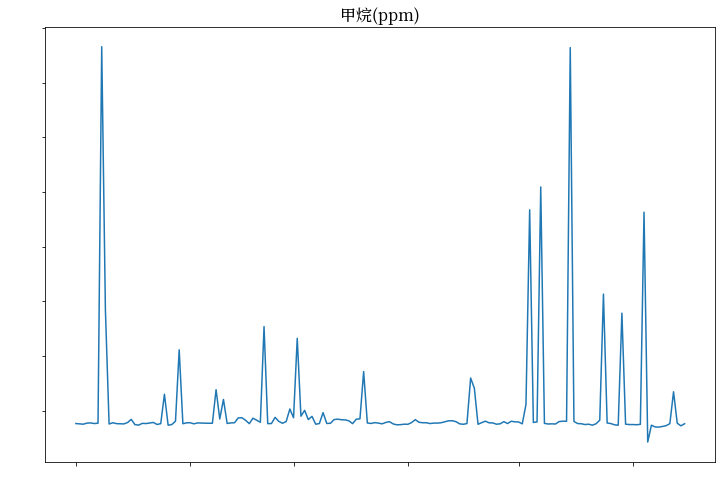

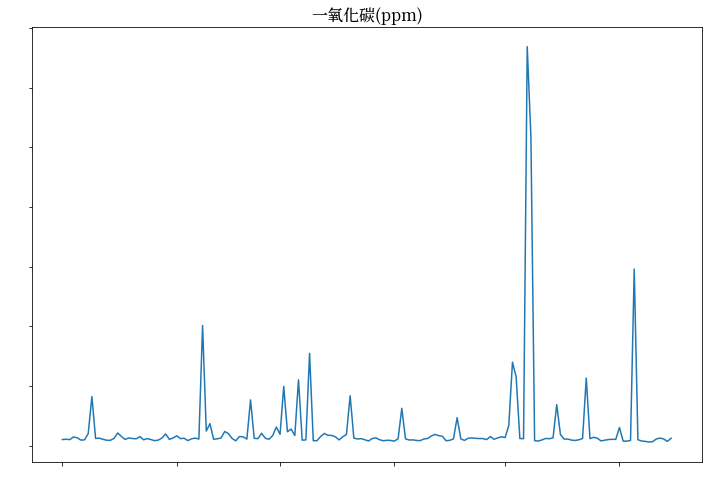

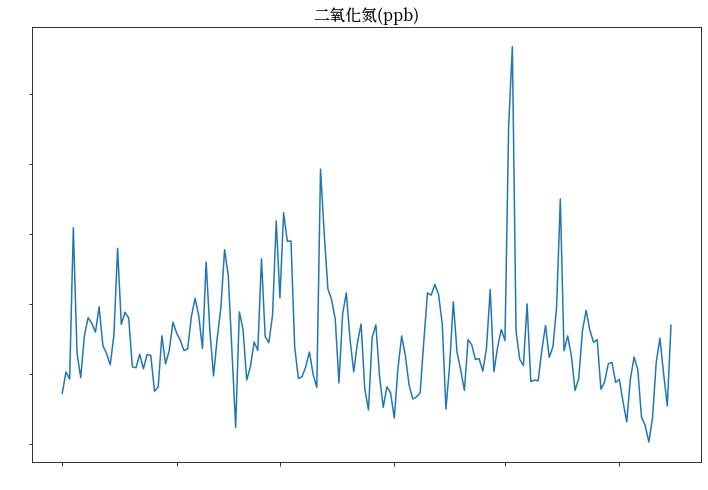

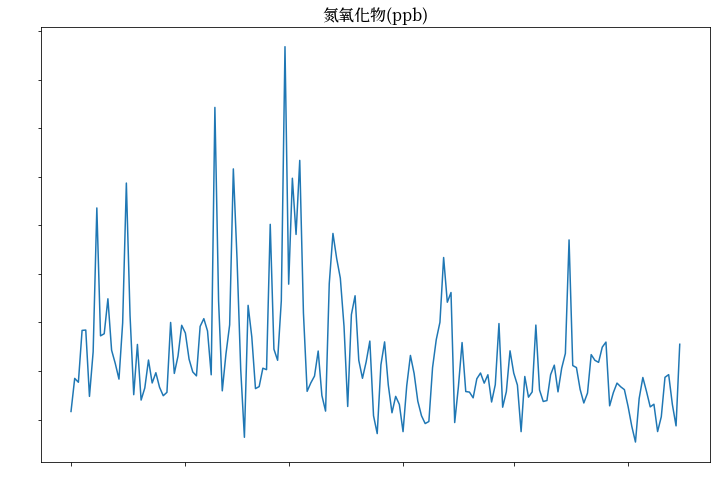

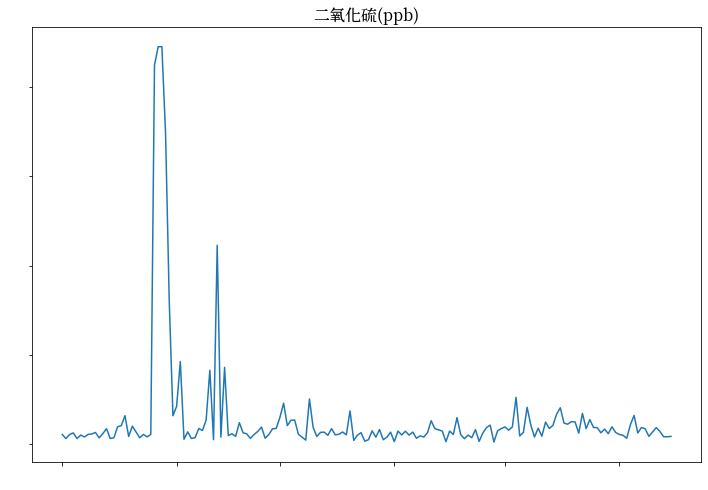

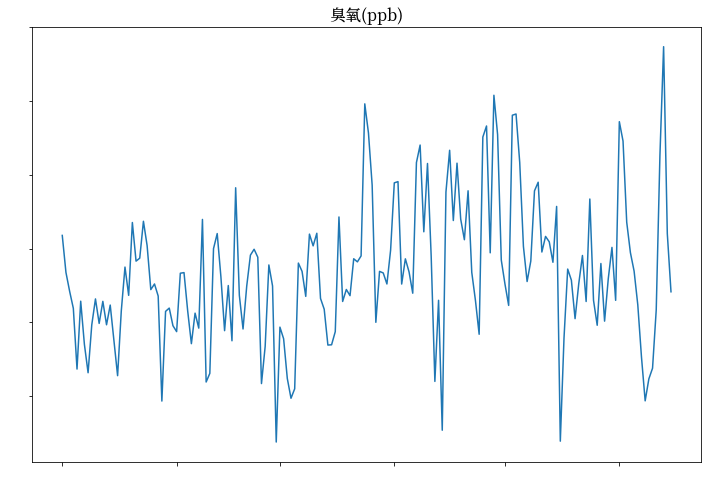

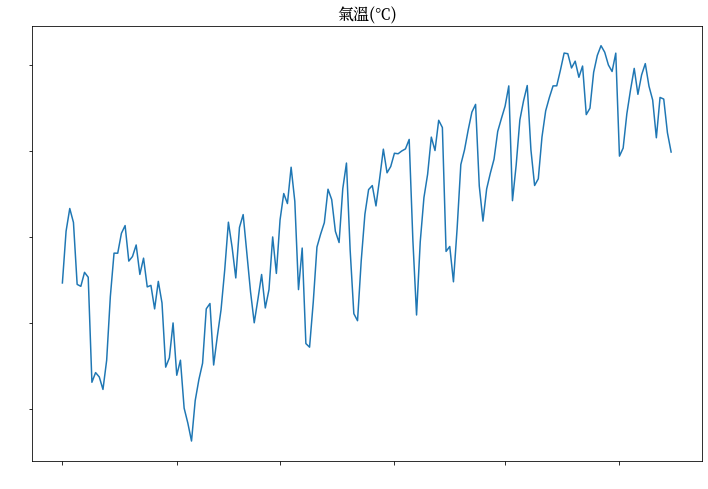

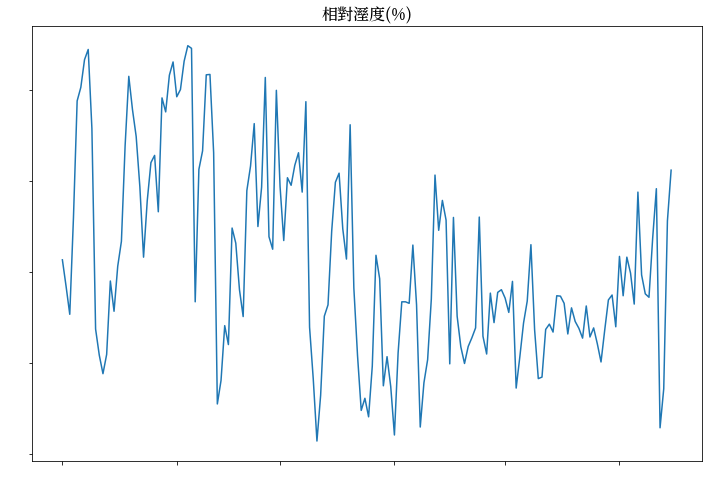

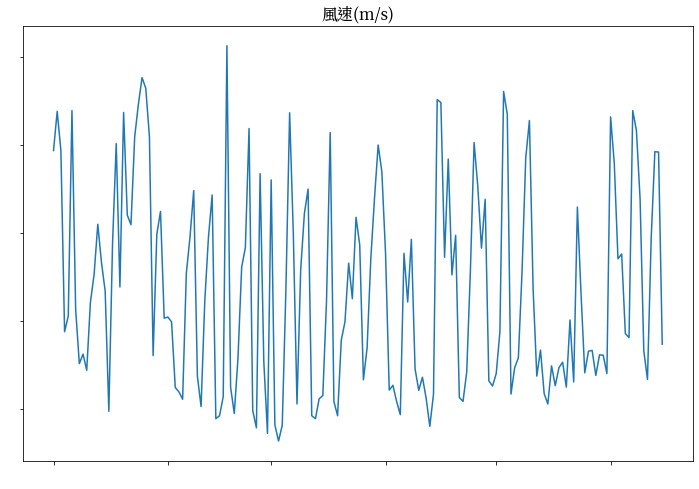

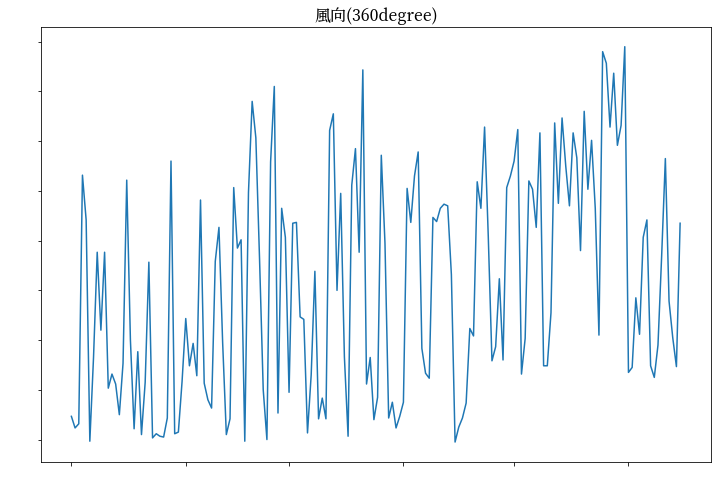

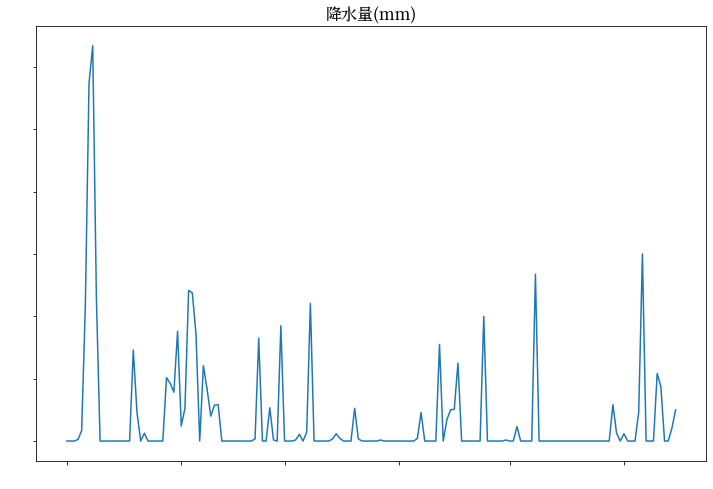

In [0]:
weather_air_df_day = resample_weather_air_df(weather_air_df, freq='D')
draw_line_plot_by_column(weather_air_df_day)

### line plot for each column(hour)

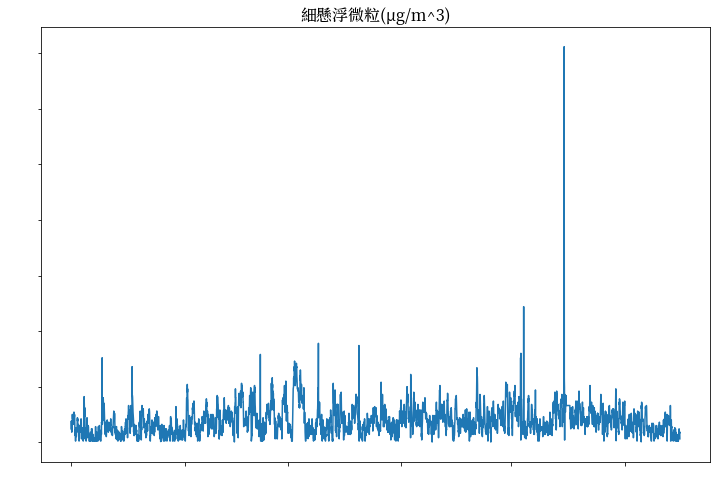

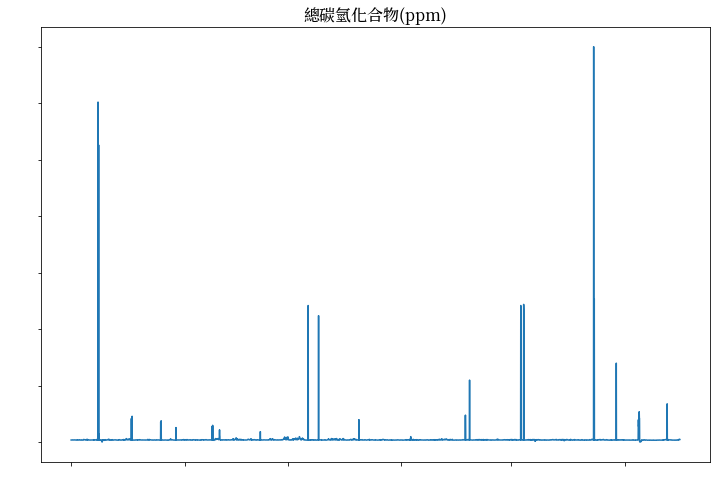

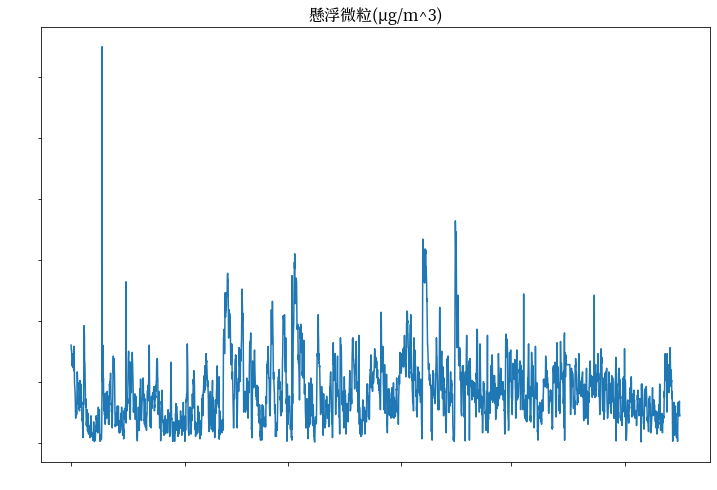

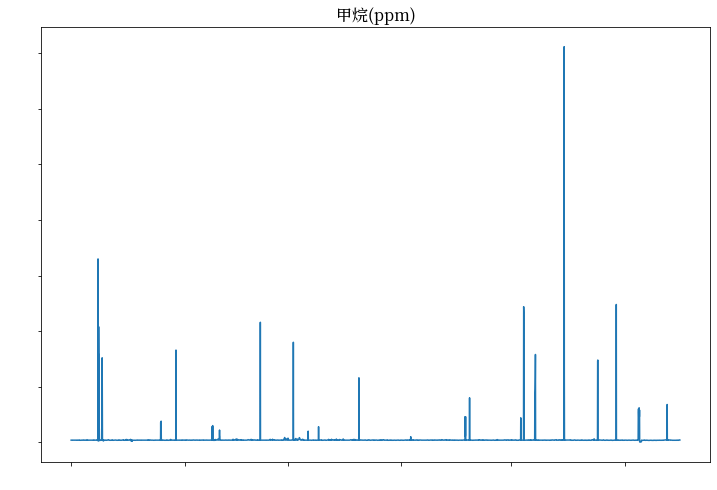

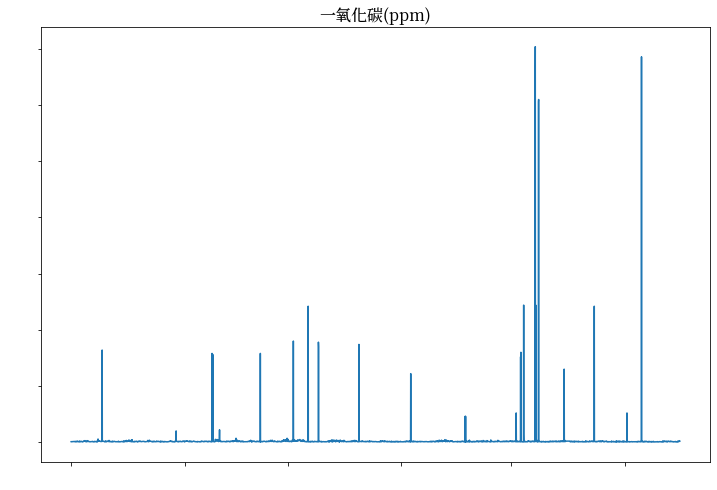

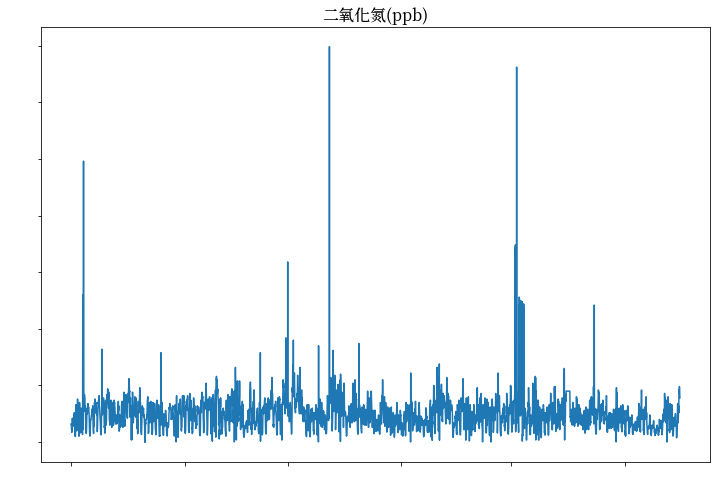

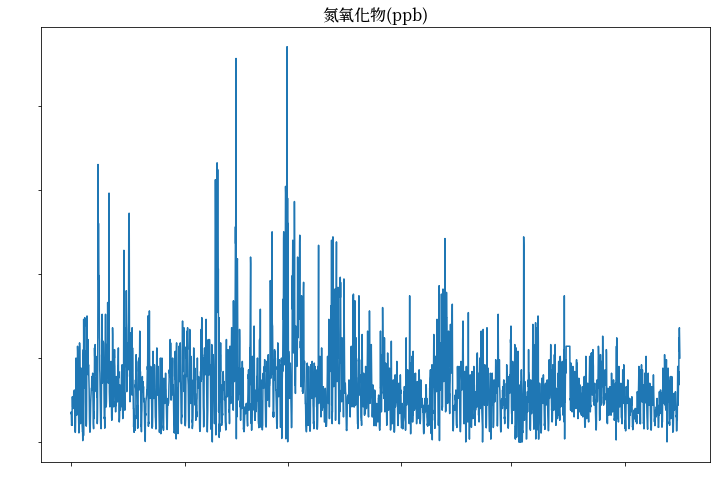

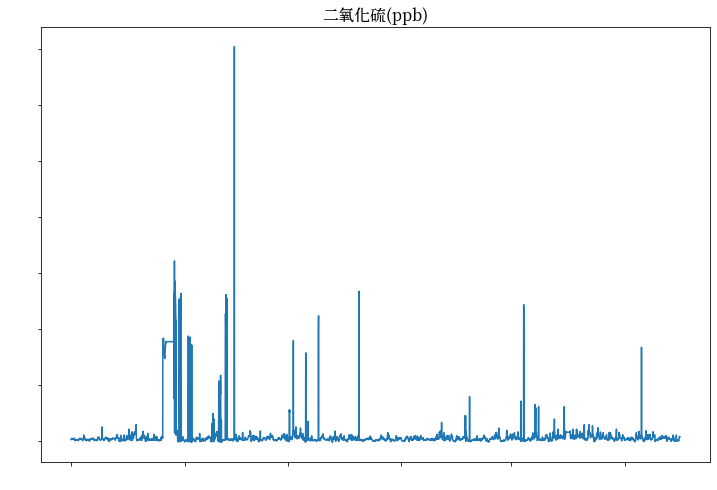

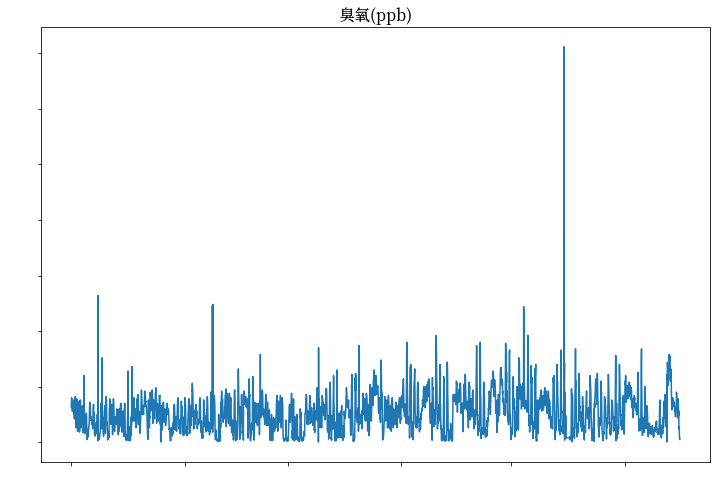

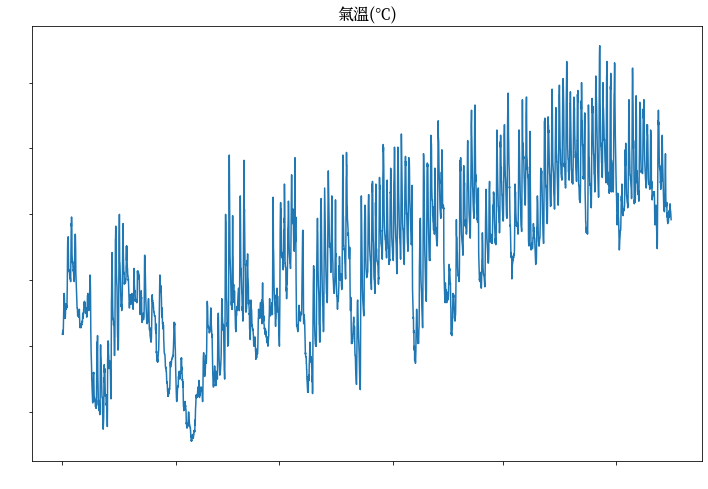

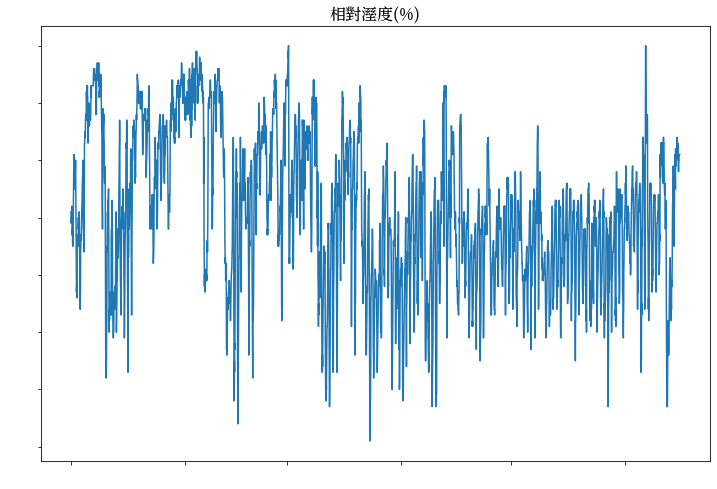

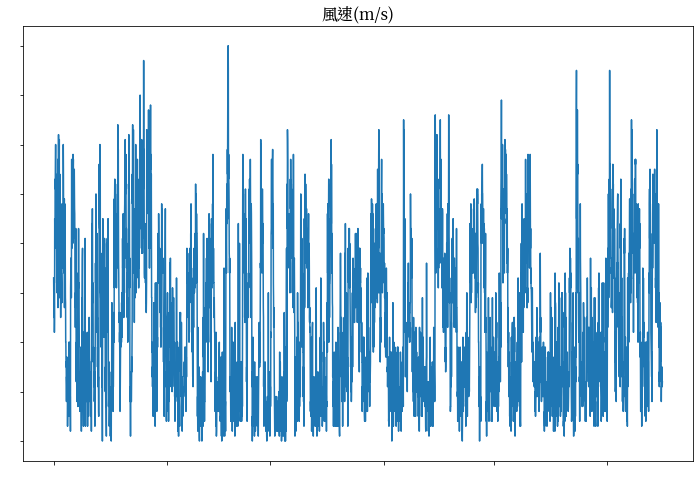

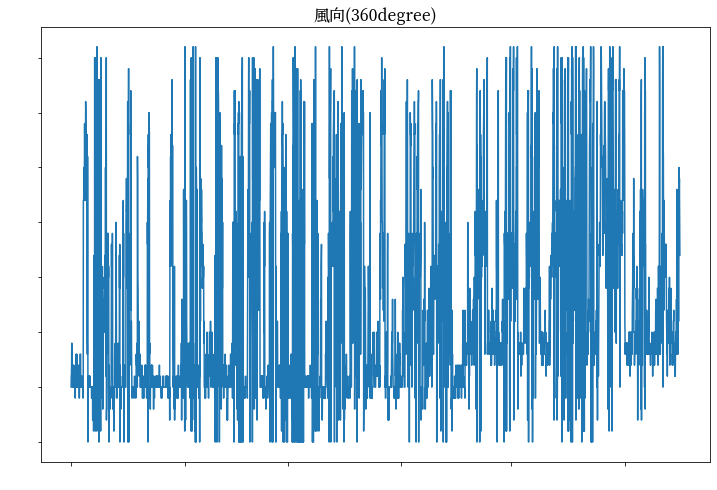

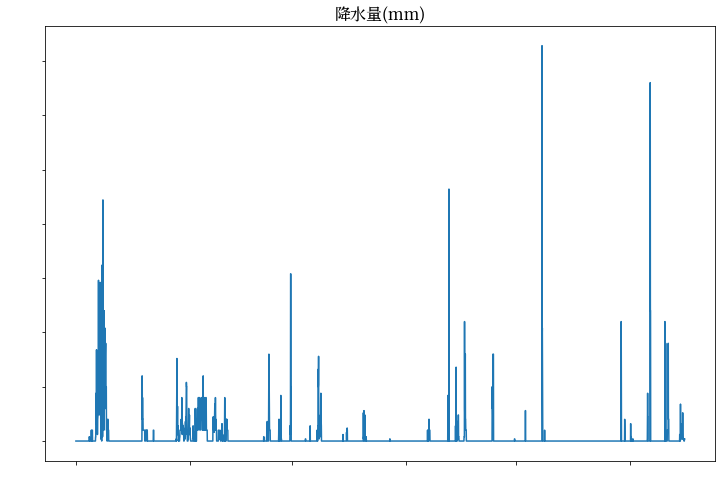

In [0]:
weather_air_df_hour = resample_weather_air_df(weather_air_df, freq='H')
draw_line_plot_by_column(weather_air_df_hour)